In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import neighbors, datasets, tree, linear_model, metrics,svm
from sklearn.model_selection import cross_val_score, train_test_split,KFold
import itertools
from itertools import permutations
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Question 5

# 1. Import Data & Data Cleaning

In [61]:
#1. Import Data
data =  pd.read_csv('car.data', sep=",",header=None)
columns=['buying_price','maintenance_price','doors','persons','luggage_size','safety','class']
data.columns=columns
data['doors']=data['doors'].astype('str')
data['persons']=data['persons'].astype('str')
data['class']=np.where(data['class']=='acc','acceptable',np.where(data['class']=='unacc','unacceptable',np.where(data['class']=='vgood','very good',data['class'])))
data['buying_price']=np.where(data['buying_price']=='vhigh','very high',data['buying_price'])
data['maintenance_price']=np.where(data['maintenance_price']=='vhigh','very high',data['maintenance_price'])
data.isna().sum()

buying_price         0
maintenance_price    0
doors                0
persons              0
luggage_size         0
safety               0
class                0
dtype: int64

# 2. Data Exploration

Text(0.5, 1.0, 'Distribution of car class')

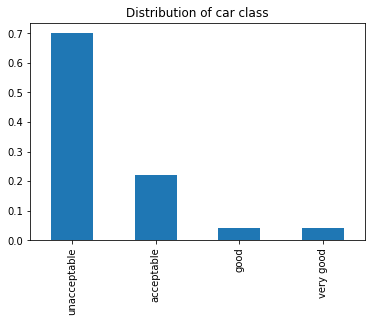

In [62]:
tem=data['class'].value_counts()
round(tem/len(data['class']),2).plot(kind='bar')
plt.title('Distribution of car class')
# We notice that most cars are in unacceptable condition. Actually, 70% of the cars are all in unacceptable condition
# Hence the data is imbalanced.

Text(0.5, 1.0, 'Buying Price vs Class')

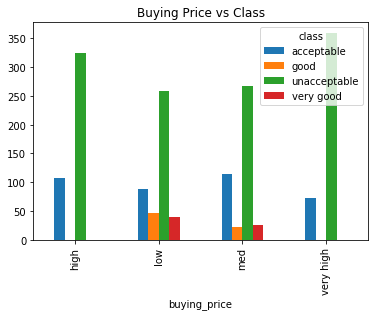

In [63]:
data.groupby(['buying_price','class']).buying_price.count().unstack().plot(kind='bar')
plt.title('Buying Price vs Class')
# Apparently, not matter how high the price is most of the cars are in unacceptable condition

Text(0.5, 1.0, 'Class vs Maintenance Price')

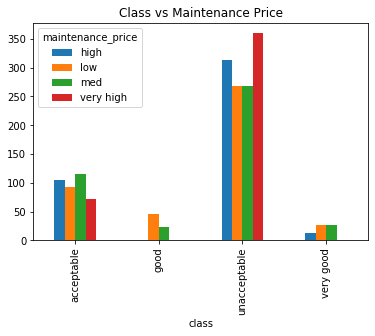

In [64]:
data.groupby(['class','maintenance_price']).maintenance_price.count().unstack().plot(kind='bar')
plt.title('Class vs Maintenance Price')

# 3. Split the train (80%) & test data (20%)

In [65]:
x_train,x_test,y_train,y_test = train_test_split(data.loc[:,data.columns!='class'],data['class'],test_size=0.2,random_state=9)

# 4. SMOTEN to fix imbalanced train data

In [66]:
from imblearn.over_sampling import SMOTE, SMOTEN
sm = SMOTEN(random_state=42)
x_train_bal, y_train_bal = sm.fit_resample(x_train, y_train)
x_train_bal['buying_price']=x_train_bal['buying_price'].astype(str)
x_train_bal['maintenance_price']=x_train_bal['maintenance_price'].astype(str)
x_train_bal['doors']=x_train_bal['doors'].astype(str)
x_train_bal['persons']=x_train_bal['persons'].astype(str)
x_train_bal['luggage_size']=x_train_bal['luggage_size'].astype(str)
x_train_bal['safety']=x_train_bal['safety'].astype(str)
y_train_bal=y_train_bal.astype(str)

In [67]:
y_train_bal.value_counts()

good            972
unacceptable    972
acceptable      972
very good       972
Name: class, dtype: int64

# 5. Performance Metric  
Given that the costs of misclassifing different classes are similar, I use **accuracy** as my evaluation metric.

# 6. Treat the ordinay data as categorical data and transfer to dummies

In [68]:
# Transfer categorical variables into dummy format
x_train_bal_dum=pd.get_dummies(x_train_bal,columns=x_train_bal.columns)

# 7. Use Nested Grid Search CV to find the best model

In [69]:
# 1. Create the Classifier
t=tree.DecisionTreeClassifier(random_state=9)
knn=neighbors.KNeighborsClassifier()
s=svm.SVC(kernel='rbf',random_state=9)

# 2. Create the parameter grid
tree_grid={'criterion':['gini','entropy'],
           'max_depth':list(range(30))}
knn_grid={'weights':['uniform','distance'],
          'n_neighbors':list(range(5,31))}
svm_grid={'C':[0.1,1,5,10,50,100],
          'gamma':[1,5,10,15,20,25,30,50,100]}

# 3. Create the CV
inner_cv = KFold(n_splits=5, shuffle=True, random_state=9)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=9)

#################################
# 4-1-1. Gried-search CV for SVM
clf = GridSearchCV(estimator=s, param_grid=svm_grid, cv=inner_cv,scoring='accuracy')

# 4-1-2. Nested CV for SVM
nested_score = cross_val_score(clf, X=x_train_bal_dum, y=y_train_bal, cv=outer_cv,scoring='accuracy')

# 4-1-3. Result for Nested CV
svm_result=nested_score.mean()

#################################
# 4-2-1. Gried-search CV for Decision Tree
clf = GridSearchCV(estimator=t, param_grid=tree_grid, cv=inner_cv,scoring='accuracy')

# 4-2-2. Nested CV for Decision Tree
nested_score = cross_val_score(clf, X=x_train_bal_dum, y=y_train_bal, cv=outer_cv,scoring='accuracy')

# 4-2-3. Result for Nested CV
tree_result=nested_score.mean()

#################################
# 4-3-1. Gried-search CV for KNN
clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv,scoring='accuracy')

# 4-3-2. Nested CV for KNN
nested_score = cross_val_score(clf, X=x_train_bal_dum, y=y_train_bal, cv=outer_cv,scoring='accuracy')

# 4-3-3. Result for Nested CV
knn_result=nested_score.mean()

print('Average Performance of SVM Classifier: {}%'.format(round(svm_result*100,2)))
print('Average Performance of Decision Tree Classifier: {}%'.format(round(tree_result*100,2)))
print('Average Performance of KNN Classifier: {}%'.format(round(knn_result*100,2)))

Average Performance of SVM Classifier: 97.97%
Average Performance of Decision Tree Classifier: 98.38%
Average Performance of KNN Classifier: 93.03%


### According to the result of the Nested Grid Search CV, I will use the Decision Tree classifier.

# 8. Grid Search CV on Decision Tree to find the best hyper-paratmeters

In [70]:
x_test_dum=pd.get_dummies(x_test,columns=x_test.columns)

# 1. Create estimator
t=tree.DecisionTreeClassifier(random_state=9)

# 2. Create parameter grid
tree_grid={'criterion':['gini','entropy'],
           'max_depth':list(range(30))}

# 3. Grid-search
model = GridSearchCV(estimator=t, param_grid=tree_grid, cv=5,scoring='accuracy')

# 4. Fit the model
model.fit(x_train_bal_dum,y_train_bal)

# 5. Predict & Result
print ("With CV grid search, I found the best hyperparameter is criterion={} and max_depth={}.".format(model.best_params_['criterion'],model.best_params_['max_depth']))
print("Prediction Accuracy Score on Test Data: {}%".format(round(metrics.accuracy_score(y_test, model.predict(x_test_dum))*100,2)))

With CV grid search, I found the best hyperparameter is criterion=gini and max_depth=13.
Prediction Accuracy Score on Test Data: 96.82%


# 9. Confusion Metrix of Test Data & Summary

In [71]:
tem = pd.DataFrame({'Actual':y_test,
                    'Predict':model.predict(x_test_dum)})
pd.crosstab(index=tem['Predict'],columns=tem['Actual'])

Actual,acceptable,good,unacceptable,very good
Predict,,,,
acceptable,72,0,3,0
good,2,14,1,0
unacceptable,4,0,234,0
very good,1,0,0,15


In [72]:
pre_score=metrics.precision_score(y_test,model.predict(x_test_dum),average=None)
print('{}% of cases that are predicted as acceptable are actually acceptable.'.format(round(pre_score[0]*100,2)))
print('{}% of cases that are predicted as good are actually good.'.format(round(pre_score[1]*100,2)))
print('{}% of cases that are predicted as unacceptable are actually unacceptable.'.format(round(pre_score[2]*100,2)))
print('{}% of cases that are predicted as very good are actually very good.'.format(round(pre_score[3]*100,2)))
print('In general, the model is good at predicting all four classes. It is only slighly bad at predicting good cases.')
print('The precisions at predicting acceptable, unacceptable, and very good cases are all higher than 90%.')
print('Yet, the precisions at predicting good cases are only a little more than 80%.')

96.0% of cases that are predicted as acceptable are actually acceptable.
82.35% of cases that are predicted as good are actually good.
98.32% of cases that are predicted as unacceptable are actually unacceptable.
93.75% of cases that are predicted as very good are actually very good.
In general, the model is good at predicting all four classes. It is only slighly bad at predicting good cases.
The precisions at predicting acceptable, unacceptable, and very good cases are all higher than 90%.
Yet, the precisions at predicting good cases are only a little more than 80%.


# 10. Treat ordinal data as numeric data  


In [73]:
x_train_bal_num = x_train_bal.copy()
x_train_bal_num[x_train_bal_num=='low']=1
x_train_bal_num[x_train_bal_num=='med']=2
x_train_bal_num[x_train_bal_num=='high']=3
x_train_bal_num[x_train_bal_num=='very high']=4
x_train_bal_num[x_train_bal_num=='5more']=5
x_train_bal_num['persons']=x_train_bal_num['persons'].replace(['2','4','more'],[1,2,3])
x_train_bal_num['luggage_size']=x_train_bal_num['luggage_size'].replace(['small','med','big'],[1,2,3])
x_train_bal_num[x_train_bal_num.columns] = x_train_bal_num[x_train_bal_num.columns].apply(pd.to_numeric, errors='coerce', axis=1)

x_test_num = x_test.copy()
x_test_num[x_test_num=='low']=1
x_test_num[x_test_num=='med']=2
x_test_num[x_test_num=='high']=3
x_test_num[x_test_num=='very high']=4
x_test_num[x_test_num=='5more']=5
x_test_num['persons']=x_test_num['persons'].replace(['2','4','more'],[1,2,3])
x_test_num['luggage_size']=x_test_num['luggage_size'].replace(['small','med','big'],[1,2,3])
x_test_num[x_test_num.columns] = x_test_num[x_test_num.columns].apply(pd.to_numeric, errors='coerce', axis=1)



# 11. Use Nested Grid Search CV to find the best model

In [74]:
# 1. Create the Classifier
t=tree.DecisionTreeClassifier(random_state=10)
knn=neighbors.KNeighborsClassifier()
s=svm.SVC(kernel='rbf',random_state=10)

# 2. Create the parameter grid
tree_grid={'criterion':['gini','entropy'],
           'max_depth':list(range(30))}
knn_grid={'weights':['uniform','distance'],
          'n_neighbors':list(range(5,31))}
svm_grid={'C':[0.1,1,5,10,50,100],
          'gamma':[1,5,10,15,20,25,30,50,100]}

# 3. Create the CV
inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=10)

# 4-1-1. Gried-search CV for SVM
clf = GridSearchCV(estimator=s, param_grid=svm_grid, cv=inner_cv,scoring='accuracy')

# 4-1-2. Nested CV for SVM
nested_score = cross_val_score(clf, X=x_train_bal_num, y=y_train_bal, cv=outer_cv,scoring='accuracy')

# 4-1-3. Result for Nested CV
svm_result=nested_score.mean()

#############################################
# 4-2-1. Gried-search CV for Decision Tree
clf = GridSearchCV(estimator=t, param_grid=tree_grid, cv=inner_cv,scoring='accuracy')

# 4-2-2. Nested CV for Decision Tree
nested_score = cross_val_score(clf, X=x_train_bal_num, y=y_train_bal, cv=outer_cv,scoring='accuracy')

# 4-2-3. Result for Nested CV
tree_result=nested_score.mean()

#############################################
# 4-3-1. Gried-search CV for KNN
clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv,scoring='accuracy')

# 4-3-2. Nested CV for KNN
nested_score = cross_val_score(clf, X=x_train_bal_num, y=y_train_bal, cv=outer_cv,scoring='accuracy')

# 4-3-3. Result for Nested CV
knn_result=nested_score.mean()

print('Average Performance of SVM Classifier: {}%'.format(round(svm_result*100,2)))
print('Average Performance of Decision Tree Classifier: {}%'.format(round(tree_result*100,2)))
print('Average Performance of KNN Classifier: {}%'.format(round(knn_result*100,2)))

Average Performance of SVM Classifier: 99.54%
Average Performance of Decision Tree Classifier: 99.13%
Average Performance of KNN Classifier: 97.02%


### According to the result of the Nested Grid Search CV, I will use the SVM classifier.

# 12. Grid Search CV on SVM Classifier to find the best hyper-paratmeters

In [75]:
# 1. Create estimator
s=svm.SVC(kernel='rbf',random_state=10)

# 2. Create the grid
svm_grid={'C':[0.1,1,5,10,50,100],
          'gamma':[1,5,10,15,20,25,30,50,100]}

# 3. Grid Search
model = GridSearchCV(estimator=s, param_grid=svm_grid, cv=5,scoring='accuracy')

# 4. Fit the model
model.fit(x_train_bal_num,y_train_bal)

# 5. Predict & Result
print ("With CV grid search, I found the best hyperparameter is C={} and gamma={}.".format(model.best_params_['C'],model.best_params_['gamma']))
print("Prediction Accuracy Score on Test Data: {}%".format(round(metrics.accuracy_score(y_test, model.predict(x_test_num))*100,2)))

With CV grid search, I found the best hyperparameter is C=5 and gamma=1.
Prediction Accuracy Score on Test Data: 99.42%


# 13. Comparison and Conclusion  
Give that the variables are originally ordinal data, even though the model eventually gets an outstanding performance, it is **not right** to use them as numeric variables. For example, if I treat the variables as numeric, the SVM model will calculate the distance using method for continous data. Yet, **for ordinay data the distance between each category is not measureable and should not be used to calculate the distance**. Hence, we should treat them as categorical variables instead.